In [1]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pylab as plt
import pandas as pd

In [8]:
from model import get_model, get_train_test_pools, get_precision_recall, load_model, get_model_path
from catboost import CatBoostRegressor

In [1]:
# path = get_model_path(N, DIRECTION)
# model = load_model(path)

In [19]:
import os
from prepare_X import get_featrues, specs
from turnpt_analysis import get_df_turnpt_measures


import pickle, io
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from catboost import CatBoostRegressor


In [50]:
# X
CACHE=True
ADD_DIFF = 0
PCT_TRAIN = 0.75
df_features = get_featrues(specs, cache=CACHE, add_diff=ADD_DIFF)
df_features.index = df_features.index.date
df_features = df_features.shift(1)

# y
df_y = get_df_turnpt_measures(N).fillna(0)
df_y.index = df_y.tx_datetime

df_chosen_y = df_y[[DIRECTION]] # before the close of t, the agent will decide whether to enter the market by predicting if t close is a turning point 
assert type(df_chosen_y.index.values[0]) == type(df_features.index.values[0])

df_chosen_y[DIRECTION] = np.where(df_chosen_y[DIRECTION]==-1, 2, df_chosen_y[DIRECTION])

### DATA ###
df = df_chosen_y.join(df_features).dropna()
w = (
df[[DIRECTION]].join(df_y.prc_diff).
assign(weight = lambda x: np.where(x.is_turnpt!=0, x.prc_diff.abs(), np.nan)).
assign(weight = lambda x: 1+x.weight.fillna(0)).
#     assign(weight = lambda x: x.weight.fillna(x.weight.quantile(WEIGHTS_QUNATILE))).
weight
)
num_train = int(df.shape[0] * PCT_TRAIN)# DONE

y = df[DIRECTION] # DONE
y_train = y[: num_train]
y_test = y[num_train:]

w_train = w[: num_train]
w_test = w[num_train:]

X = df.iloc[:, 1:]
X_train = X.iloc[:num_train, :]
X_test = X.iloc[num_train:, :]

train_pool = Pool(X_train, y_train, weight=w_train)
test_pool = Pool(X_test, y_test, weight=w_test)

transformed OHLCV at frequency 1D
reading cache of TXF in 1D OHLCV


/home/cyyen/miniconda3/envs/stock_path_tracker/lib/python3.8/site-packages/pandas/core/groupby/groupby.py:980: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis, keys=keys)
<ipython-input-50-510885712db5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chosen_y[DIRECTION] = np.where(df_chosen_y[DIRECTION]==-1, 2, df_chosen_y[DIRECTION])


In [51]:
%%time
# train_pool, test_pool =  get_train_test_pools(N,DIRECTION, WEIGHTS_QUNATILE, CACHE=True)
# best_iter = next(map(lambda x: len(x[1])-1, model.eval_metrics(train_pool,['Precision']).items()))
# model.plot_tree(best_iter)

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 5.72 µs


In [55]:
%%time
N=5
DIRECTION='is_turnpt'
WEIGHTS_QUNATILE = 0.01

model = CatBoostClassifier(iterations=10**5, # set very large number and set early stops
                          depth=10, #fine-tune
                          learning_rate=0.1, #max: 0.5
                          loss_function='MultiClass', 
                          l2_leaf_reg = 202, #fine-tune
                          od_type = 'Iter',
                          od_wait = 250,
#                           subsample = 0.3,
                          rsm = 0.95,
                           random_strength = 0.95,
                           bagging_temperature = 19.95
                          )

model.fit(train_pool, eval_set=test_pool)

0:	learn: 1.0944834	test: 1.0969475	best: 1.0969475 (0)	total: 421ms	remaining: 11h 41m 3s
1:	learn: 1.0893820	test: 1.0959807	best: 1.0959807 (1)	total: 830ms	remaining: 11h 31m 23s
2:	learn: 1.0834324	test: 1.0950932	best: 1.0950932 (2)	total: 1.25s	remaining: 11h 34m 3s
3:	learn: 1.0792036	test: 1.0953233	best: 1.0950932 (2)	total: 1.66s	remaining: 11h 31m
4:	learn: 1.0741568	test: 1.0953330	best: 1.0950932 (2)	total: 2.06s	remaining: 11h 28m 25s
5:	learn: 1.0674854	test: 1.0886660	best: 1.0886660 (5)	total: 2.48s	remaining: 11h 28m 20s
6:	learn: 1.0631603	test: 1.0872763	best: 1.0872763 (6)	total: 2.89s	remaining: 11h 28m 45s
7:	learn: 1.0561685	test: 1.0830492	best: 1.0830492 (7)	total: 3.31s	remaining: 11h 29m 9s
8:	learn: 1.0506670	test: 1.0830408	best: 1.0830408 (8)	total: 3.74s	remaining: 11h 33m 22s
9:	learn: 1.0458663	test: 1.0801252	best: 1.0801252 (9)	total: 4.18s	remaining: 11h 35m 56s
10:	learn: 1.0408145	test: 1.0787712	best: 1.0787712 (10)	total: 4.59s	remaining: 11h 3

In [31]:
# print('training pool')
# get_precision_recall(model, train_pool)

# print('testing pool')
# get_precision_recall(model, test_pool)

,y,pred,occurence
0,-1.0,-1.0,27
1,-1.0,1.0,5
2,0.0,-1.0,240
3,0.0,1.0,173
4,1.0,-1.0,7
5,1.0,1.0,21


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f72f8291d60>,
      dtype=object)

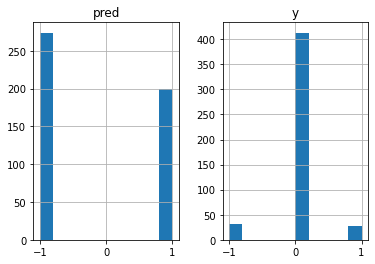

In [35]:
df_pred = (
    pd.DataFrame(model.predict(test_pool), columns=['pred']).
    assign(y=test_pool.get_label())
)

df_pred_summary = df_pred.groupby(['y', 'pred']).size().to_frame('occurence').reset_index()
df_pred_summary


df_pred[['pred', 'y']].hist()

# plot entry and exit

In [9]:
# def plot_turnpt(price, turnpts, dates_index):
#     index_upward = np.where(turnpts==1)[0]
#     index_downward = np.where(turnpts==-1)[0]
    
#     plt.figure(figsize=(20, 5))
#     plt.plot(dates_index, price, color='black', markevery=index_upward.tolist(), marker='^', markerfacecolor='red', markeredgewidth=0.0)
#     plt.plot(dates_index, price, color='black', markevery=index_downward.tolist(), marker='v', markerfacecolor='green', markeredgewidth=0.0)


# test_df_y = df_y[df_y.index.isin(y_test.index)]
# test_price = test_df_y.close.values
# test_turnpts_true = test_df_y.is_turnpt.values
# test_dates_index = test_df_y.index
# plot_turnpt(test_price, test_turnpts_true, test_dates_index)

In [ ]:
# def get_predict_class(model, pool, threshold = 0):
#     max_prob = model.predict_proba(pool).max(axis=1)
#     turnpts_pred = model.predict(pool).flatten()
#     turnpts_pred_filtered = np.where(max_prob>=threshold, turnpts_pred, 0)
#     return turnpts_pred_filtered

# test_turnpts_pred = get_predict_class(model, test_pool)
# plot_turnpt(test_price, test_turnpts_pred, test_dates_index)

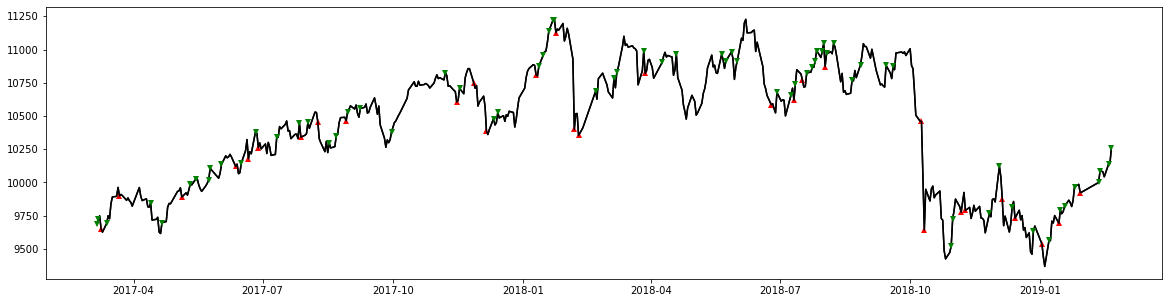

In [228]:
# # only plot 1 or -1 when prob > thereshold
# # noises during 2018-M7 disappear
# test_turnpts_pred = get_predict_class(model, test_pool, threshold=0.6)
# plot_turnpt(test_price, test_turnpts_pred, test_dates_index)

# plot NAV

In [231]:
# test_df_y['is_turnpt_pred'] = get_predict_class(model, test_pool)
# test_df_y.head()

<ipython-input-231-74b3a4708c79>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_y['is_turnpt_pred'] =get_predict_class(model, test_pool)


,tx_datetime,N,open,high,low,close,vol,maturity,day_to_maturity,is_turnpt_upward,is_turnpt_downward,is_turnpt,next_dt_turnpt,prc_diff,duration,slope,is_turnpt_pred
tx_datetime,,,,,,,,,,,,,,,,,
2017-03-06,2017-03-06,1,9639.0,9684.0,9619.0,9683.0,196244.0,2017-03-15,-9,0.0,0.0,0.0,2017-03-07,44.0,1,44.000000,-1.0
2017-03-07,2017-03-07,1,9693.0,9734.0,9682.0,9727.0,188700.0,2017-03-15,-8,0.0,0.0,0.0,2017-03-08,21.0,1,21.000000,-1.0
2017-03-08,2017-03-08,1,9736.0,9765.0,9701.0,9748.0,226610.0,2017-03-15,-7,0.0,1.0,-1.0,2017-03-09,-96.0,1,-96.000000,0.0
2017-03-09,2017-03-09,1,9739.0,9742.0,9642.0,9652.0,277266.0,2017-03-15,-6,0.0,0.0,0.0,2017-03-10,-27.0,1,-27.000000,1.0
2017-03-10,2017-03-10,1,9647.0,9652.0,9555.0,9625.0,307656.0,2017-03-15,-5,1.0,0.0,1.0,2017-03-13,67.0,3,22.333333,1.0


In [350]:
# # test_df_y
# (
#     test_df_y.query('is_turnpt_pred != 0').loc[:, ['tx_datetime', 'close']].
#     assign(entry = lambda x: x.tx_datetime, 
#            exit = lambda x: x.tx_datetime.shift(-1)).dropna().
#     assign(p_entry = lambda x: x.close.loc[x.entry],# 
# #            p_exit = lambda x: x.close[x.exit],# 
# #            ret = lambda x: x.p_exit.div(x.p_entry)-1
#     )
# #     loc[:, ['entry', 'exit']].
# #     join(test_df_y, how='right')
# )

# check X

# show metrics